In [237]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append('../../nn_physical_concepts')
from scinet import *
import scinet.ed_copernicus as edc

In [428]:

import pandas as pd

df = pd.read_csv('../data/transient_energy_data_ch41step.csv')

In [429]:
df_rates = pd.read_csv('../data/constant_energy_data_ch41step.csv')


In [398]:

kf = np.zeros((1,1001))
for i in range(1001):
    kf[0,i] = float(df_rates['kf'][i][1:-1])

In [399]:
kf = kf[0]

In [400]:
def my_load_traindata(df,thalf = 1.25e-5):
    mydf = df[df['t [s]'] <=thalf]
    in1 = np.zeros((2001*25,25))
    in2 = np.zeros((2001*25,1))
    out = np.zeros((2001*25,1))
    for j in range(25):
        for i in range(1000,3001):
            in1[(i-1000)*25 + j,:] = mydf[mydf['T [K]']==i]['Yco2']
    in2[:,0] = mydf['t [s]']
    out[:,0] = mydf['Yco2']
    return [in1, in2, out]

def my_load_traindata_3(df,thalf = 1.25e-5):
    mydf = df[df['t [s]'] <=thalf]
    in1 = np.zeros((2001*25,25))
    in2 = np.zeros((2001*25,3))
    out = np.zeros((2001*25,1))
    for j in range(25):
        for i in range(1000,3001):
            in1[(i-1000)*25 + j,:] = mydf[mydf['T [K]']==i]['Yco2']
    in2[:,0] = mydf['t [s]']
    in2[:,1] = mydf['Yo2']
    in2[:,2] = mydf['Ych4']
    out[:,0] = mydf['Yco2']
    return [in1, in2, out]

def my_load_testdata(df,T,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((51,25))
    in2 = np.zeros((51,1))
    for i in range(51): 
        in1[i,:] = mydf[mydf['T [K]']==T]['Yco2']
        in2[i,0] = i*5e-7
    out = in2
    return [in1,in2,out]

def my_load_testdata3(df,T,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((51,25))
    in2 = np.zeros((51,3))
    for i in range(51): 
        in1[i,:] = mydf[mydf['T [K]']==T]['Yco2']
        in2[i,0] = i*5e-7
    in2[:,1] = df[df['T [K]']==T]['Yo2']
    in2[:,2] = df[df['T [K]']==T]['Ych4']
    out = np.zeros((51,1))
    return [in1,in2,out]

def my_load_testdata_singletime(df,T,time,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((1,25))
    in2 = np.zeros((1,3))
    in1[0,:] = mydf[mydf['T [K]']==T]['Yco2']
    in2[0,0] = time
    in2[:,1] = df[(df['T [K]']==T) & (df['t [s]']<(time+4e-7))& (df['t [s]']>(time-4e-7))]['Yo2']
    in2[:,2] = df[(df['T [K]']==T) & (df['t [s]']<(time+4e-7))& (df['t [s]']>(time-4e-7))]['Ych4']
    out = np.zeros((1,1))
    return [in1,in2,out]

from sklearn.model_selection import train_test_split

def my_train_test_split(train_data3,test_size = 0.25,random_state=42):
    in1train, in1test = train_test_split(train_data3[0], test_size=test_size, random_state=random_state)
    in2train, in2test = train_test_split(train_data3[1], test_size=test_size, random_state=random_state)
    outtrain, outtest = train_test_split(train_data3[2], test_size=test_size, random_state=random_state)
    return [in1train,in2train,outtrain],[in1test,in2test,outtest]

In [413]:
#Create Table of yco2 in terms of temperature and time (answer)
def my_load_time(df):
    df['Temp'] = df['T [K]']/np.max(df['T [K]'])
    tmp = df.pivot_table(values=['Yco2','Ych4','Yo2','Temp'], index='T [K]', columns='t [s]', aggfunc='first')
    tmp = tmp.reorder_levels([1, 0],axis=1)
    return tmp.sort_index(axis=1)
#     return tmp.reindex(sorted(tmp.reorder_levels([1, 0],axis=1)), axis=1)

def my_load_time_energy(df):
    tmp = df
    tmp['T [K]'] = tmp['T [K]']/np.max(tmp['T [K]'])
    tmp = tmp.pivot_table(values=['Yco2','T [K]'], index='initT', columns='t [s]', aggfunc='first')
    tmp = tmp.reorder_levels([1, 0],axis=1)
    return tmp.sort_index(axis=1)
#     return tmp.reindex(sorted(tmp.reorder_levels([1, 0],axis=1)), axis=1)

def my_load_time_kf(df):
    tmp = df
    tmp['T [K]'] = tmp['T [K]']/np.max(tmp['T [K]'])
    tmp = tmp.pivot_table(values=['kf'], index='initT', columns='t [s]', aggfunc='first')
    tmp = tmp.reorder_levels([1, 0],axis=1)
    return tmp.sort_index(axis=1)

def my_load_ch4_co2(df):
    tmp = df
    tmp['T [K]'] = tmp['T [K]']/np.max(tmp['T [K]'])
    tmp = tmp.pivot_table(values=['Yco2','T [K]'], index='initT', columns='t [s]', aggfunc='first')
    tmp = tmp.reorder_levels([1, 0],axis=1)
    return tmp.sort_index(axis=1)
#     return tmp.reindex(sorted(tmp.reorder_levels([1, 0],axis=1)), axis=1)
    
#Create table of T,o2,ch4 (initial observation)
def my_load_initial(df):
    return df[df['t [s]']==0][['T [K]']]


In [414]:
my_load_time_kf(df)

KeyError: 'kf'

In [433]:
net_in = my_load_time_energy(df)

In [434]:
net_in

t [s]  0.000000e+00      5.000000e-07               1.000000e-06  \
              T [K] Yco2        T [K]          Yco2        T [K]   
initT                                                              
400.0      0.077174  0.0     0.077174  2.322350e-10     0.077174   
401.0      0.077367  0.0     0.077367  2.469650e-10     0.077367   
402.0      0.077560  0.0     0.077560  2.625483e-10     0.077560   
403.0      0.077753  0.0     0.077753  2.790291e-10     0.077753   
404.0      0.077946  0.0     0.077946  2.964543e-10     0.077946   
405.0      0.078139  0.0     0.078139  3.148725e-10     0.078139   
406.0      0.078332  0.0     0.078332  3.343347e-10     0.078332   
407.0      0.078525  0.0     0.078525  3.548941e-10     0.078525   
408.0      0.078717  0.0     0.078717  3.766065e-10     0.078717   
409.0      0.078910  0.0     0.078910  3.995300e-10     0.078910   
410.0      0.079103  0.0     0.079103  4.237255e-10     0.079103   
411.0      0.079296  0.0     0.079296  4.492563e-10     0.079296   
412.0      0.079489  0.0     0.079489  4.761888e-10     0.079489   
413.0      0.079682  0.0     0.079682  5.045920e-10     0.079682   
414.0      0.079875  0.0     0.079875  5.345383e-10     0.079875   
415.0      0.080068  0.0     0.080068  5.661028e-10     0.080068   
416.0      0.080261  0.0     0.080261  5.993641e-10     0.080261   
417.0      0.080454  0.0     0.080454  6.344042e-10     0.080454   
418.0      0.080647  0.0     0.080647  6.713083e-10     0.080647   
419.0      0.080840  0.0     0.080840  7.101654e-10     0.080840   
420.0      0.081033  0.0     0.081033  7.510683e-10     0.081033   
421.0      0.081226  0.0     0.081226  7.941135e-10     0.081226   
422.0      0.081419  0.0     0.081419  8.394016e-10     0.081419   
423.0      0.081611  0.0     0.081611  8.870373e-10     0.081611   
424.0      0.081804  0.0     0.081804  9.371297e-10     0.081804   
425.0      0.081997  0.0     0.081997  9.897923e-10     0.081997   
426.0      0.082190  0.0     0.082190  1.045143e-09     0.082190   
427.0      0.082383  0.0     0.082383  1.103305e-09     0.082383   
428.0      0.082576  0.0     0.082576  1.164405e-09     0.082576   
429.0      0.082769  0.0     0.082769  1.228578e-09     0.082769   
...             ...  ...          ...           ...          ...   
2371.0     0.457449  0.0     0.660359  1.737774e-01     0.905510   
2372.0     0.457642  0.0     0.660825  1.740230e-01     0.905982   
2373.0     0.457835  0.0     0.661290  1.742686e-01     0.906454   
2374.0     0.458028  0.0     0.661756  1.745140e-01     0.906925   
2375.0     0.458221  0.0     0.662221  1.747595e-01     0.907396   
2376.0     0.458414  0.0     0.662687  1.750048e-01     0.907866   
2377.0     0.458606  0.0     0.663152  1.752501e-01     0.908335   
2378.0     0.458799  0.0     0.663617  1.754953e-01     0.908804   
2379.0     0.458992  0.0     0.664082  1.757405e-01     0.909272   
2380.0     0.459185  0.0     0.664547  1.759856e-01     0.909739   
2381.0     0.459378  0.0     0.665012  1.762306e-01     0.910206   
2382.0     0.459571  0.0     0.665477  1.764755e-01     0.910672   
2383.0     0.459764  0.0     0.665941  1.767204e-01     0.911137   
2384.0     0.459957  0.0     0.666406  1.769652e-01     0.911602   
2385.0     0.460150  0.0     0.666870  1.772099e-01     0.912066   
2386.0     0.460343  0.0     0.667335  1.774545e-01     0.912530   
2387.0     0.460536  0.0     0.667799  1.776991e-01     0.912993   
2388.0     0.460729  0.0     0.668263  1.779436e-01     0.913455   
2389.0     0.460922  0.0     0.668727  1.781880e-01     0.913916   
2390.0     0.461115  0.0     0.669192  1.784324e-01     0.914377   
2391.0     0.461308  0.0     0.669655  1.786767e-01     0.914838   
2392.0     0.461500  0.0     0.670119  1.789208e-01     0.915297   
2393.0     0.461693  0.0     0.670583  1.791650e-01     0.915756   
2394.0     0.461886  0.0     0.671047  1.794090e-01     0.916215   
2395.0     0.462079  0.0     0.671510  1.796530e-01     

In [435]:
net_in.shape

(2001, 102)

In [436]:
net_in.shape[1]

102

In [437]:
from sklearn.model_selection import train_test_split
net_train, net_test = train_test_split( net_in, test_size=0.25, random_state=42)

In [438]:
np.sum(np.sum(np.isnan(net_train)))

0

In [439]:
net_test

t [s]  0.000000e+00      5.000000e-07               1.000000e-06  \
              T [K] Yco2        T [K]          Yco2        T [K]   
initT                                                              
1794.0     0.346125  0.0     0.404464  4.671106e-02     0.514170   
753.0      0.145280  0.0     0.145320  2.248693e-05     0.145360   
1734.0     0.334549  0.0     0.382618  3.808592e-02     0.470142   
1306.0     0.251973  0.0     0.259496  5.395781e-03     0.268681   
1690.0     0.326060  0.0     0.367400  3.248774e-02     0.440234   
1674.0     0.322973  0.0     0.362032  3.060119e-02     0.429924   
1339.0     0.258340  0.0     0.267350  6.524158e-03     0.278651   
2132.0     0.411337  0.0     0.548346  1.148954e-01     0.770927   
465.0      0.089715  0.0     0.089715  7.256051e-09     0.089715   
1447.0     0.279177  0.0     0.294619  1.150672e-02     0.316011   
456.0      0.087978  0.0     0.087978  4.779931e-09     0.087978   
1433.0     0.276476  0.0     0.290935  1.073642e-02     0.310692   
1867.0     0.360210  0.0     0.432734  5.875821e-02     0.571205   
984.0      0.189848  0.0     0.190570  4.608189e-04     0.191318   
774.0      0.149332  0.0     0.149388  3.189272e-05     0.149444   
675.0      0.130231  0.0     0.130241  5.062716e-06     0.130250   
1146.0     0.221103  0.0     0.223848  1.869292e-03     0.226869   
528.0      0.101870  0.0     0.101870  9.009159e-08     0.101870   
1844.0     0.355772  0.0     0.423631  5.478029e-02     0.552968   
1914.0     0.369278  0.0     0.451876  6.739295e-02     0.608740   
1074.0     0.207212  0.0     0.208803  1.054687e-03     0.210499   
1728.0     0.333392  0.0     0.380503  3.728667e-02     0.465935   
1661.0     0.320465  0.0     0.357736  2.912578e-02     0.421778   
1484.0     0.286316  0.0     0.304592  1.374266e-02     0.330872   
2173.0     0.419248  0.0     0.567435  1.247994e-01     0.797360   
499.0      0.096275  0.0     0.096275  3.060880e-08     0.096275   
1502.0     0.289788  0.0     0.309574  1.494086e-02     0.338553   
1365.0     0.263356  0.0     0.273685  7.533463e-03     0.286934   
1192.0     0.229978  0.0     0.233742  2.604079e-03     0.237989   
429.0      0.082769  0.0     0.082769  1.228578e-09     0.082769   
...             ...  ...          ...           ...          ...   
996.0      0.192163  0.0     0.192972  5.189419e-04     0.193812   
1218.0     0.234995  0.0     0.239449  3.108610e-03     0.244556   
1673.0     0.322780  0.0     0.361700  3.048588e-02     0.429290   
1713.0     0.330498  0.0     0.375270  3.533831e-02     0.455591   
886.0      0.170940  0.0     0.171196  1.551136e-04     0.171455   
1080.0     0.208370  0.0     0.210039  1.109272e-03     0.211822   
815.0      0.157242  0.0     0.157344  5.987140e-05     0.157448   
673.0      0.129845  0.0     0.129854  4.850390e-06     0.129863   
1413.0     0.272617  0.0     0.285754  9.704238e-03     0.303361   
1886.0     0.363875  0.0     0.440387  6.216821e-02     0.586363   
1855.0     0.357894  0.0     0.427962  5.666210e-02     0.561670   
650.0      0.125408  0.0     0.125413  2.906975e-06     0.125419   
813.0      0.156856  0.0     0.156956  5.814633e-05     0.157056   
1786.0     0.344582  0.0     0.401478  4.549430e-02     0.508115   
1849.0     0.356737  0.0     0.425595  5.563094e-02     0.556918   
1115.0     0.215123  0.0     0.217311  1.473631e-03     0.219684   
710.0      0.136984  0.0     0.137003  1.029899e-05     0.137022   
1965.0     0.379117  0.0     0.473415  7.749242e-02     0.649158   
781.0      0.150682  0.0     0.150744  3.568164e-05     0.150807   
2106.0     0.406321  0.0     0.536342  1.087262e-01     0.753407   
825.0      0.159171  0.0     0.159289  6.914723e-05     0.159408   
2275.0     0.438927  0.0     0.615362  1.499937e-01     0.856892   
932.0      0.179815  0.0     0.180243  2.660015e-04     0.180681   
1152.0     0.222261  0.0     0.225125  1.954629e-03     0.228287   
1165.0     0.224769  0.0     0.227905  2.149955e-03     

In [443]:
net = nn.Network(latent_size = 3,input_size =  1,output_size = 2,time_series_length = net_in.shape[1]/2,name = 'recurrent_chem')

In [444]:
net.train(500, 32, 1e-3, np.array(net_train), np.array(net_test),beta_fun=lambda x: 0.1, euler_l2_coeff=0, test_step=10)

  0%|          | 0/500 [00:00<?, ?it/s]

In [445]:
latent = net.run(net_test, net.state_means)

In [446]:
decoded_list = net.run(net_test, net.decoded_list)

In [447]:
np.array(decoded_list).shape

(51, 501, 2)

In [448]:
net_test

t [s]  0.000000e+00      5.000000e-07               1.000000e-06  \
              T [K] Yco2        T [K]          Yco2        T [K]   
initT                                                              
1794.0     0.346125  0.0     0.404464  4.671106e-02     0.514170   
753.0      0.145280  0.0     0.145320  2.248693e-05     0.145360   
1734.0     0.334549  0.0     0.382618  3.808592e-02     0.470142   
1306.0     0.251973  0.0     0.259496  5.395781e-03     0.268681   
1690.0     0.326060  0.0     0.367400  3.248774e-02     0.440234   
1674.0     0.322973  0.0     0.362032  3.060119e-02     0.429924   
1339.0     0.258340  0.0     0.267350  6.524158e-03     0.278651   
2132.0     0.411337  0.0     0.548346  1.148954e-01     0.770927   
465.0      0.089715  0.0     0.089715  7.256051e-09     0.089715   
1447.0     0.279177  0.0     0.294619  1.150672e-02     0.316011   
456.0      0.087978  0.0     0.087978  4.779931e-09     0.087978   
1433.0     0.276476  0.0     0.290935  1.073642e-02     0.310692   
1867.0     0.360210  0.0     0.432734  5.875821e-02     0.571205   
984.0      0.189848  0.0     0.190570  4.608189e-04     0.191318   
774.0      0.149332  0.0     0.149388  3.189272e-05     0.149444   
675.0      0.130231  0.0     0.130241  5.062716e-06     0.130250   
1146.0     0.221103  0.0     0.223848  1.869292e-03     0.226869   
528.0      0.101870  0.0     0.101870  9.009159e-08     0.101870   
1844.0     0.355772  0.0     0.423631  5.478029e-02     0.552968   
1914.0     0.369278  0.0     0.451876  6.739295e-02     0.608740   
1074.0     0.207212  0.0     0.208803  1.054687e-03     0.210499   
1728.0     0.333392  0.0     0.380503  3.728667e-02     0.465935   
1661.0     0.320465  0.0     0.357736  2.912578e-02     0.421778   
1484.0     0.286316  0.0     0.304592  1.374266e-02     0.330872   
2173.0     0.419248  0.0     0.567435  1.247994e-01     0.797360   
499.0      0.096275  0.0     0.096275  3.060880e-08     0.096275   
1502.0     0.289788  0.0     0.309574  1.494086e-02     0.338553   
1365.0     0.263356  0.0     0.273685  7.533463e-03     0.286934   
1192.0     0.229978  0.0     0.233742  2.604079e-03     0.237989   
429.0      0.082769  0.0     0.082769  1.228578e-09     0.082769   
...             ...  ...          ...           ...          ...   
996.0      0.192163  0.0     0.192972  5.189419e-04     0.193812   
1218.0     0.234995  0.0     0.239449  3.108610e-03     0.244556   
1673.0     0.322780  0.0     0.361700  3.048588e-02     0.429290   
1713.0     0.330498  0.0     0.375270  3.533831e-02     0.455591   
886.0      0.170940  0.0     0.171196  1.551136e-04     0.171455   
1080.0     0.208370  0.0     0.210039  1.109272e-03     0.211822   
815.0      0.157242  0.0     0.157344  5.987140e-05     0.157448   
673.0      0.129845  0.0     0.129854  4.850390e-06     0.129863   
1413.0     0.272617  0.0     0.285754  9.704238e-03     0.303361   
1886.0     0.363875  0.0     0.440387  6.216821e-02     0.586363   
1855.0     0.357894  0.0     0.427962  5.666210e-02     0.561670   
650.0      0.125408  0.0     0.125413  2.906975e-06     0.125419   
813.0      0.156856  0.0     0.156956  5.814633e-05     0.157056   
1786.0     0.344582  0.0     0.401478  4.549430e-02     0.508115   
1849.0     0.356737  0.0     0.425595  5.563094e-02     0.556918   
1115.0     0.215123  0.0     0.217311  1.473631e-03     0.219684   
710.0      0.136984  0.0     0.137003  1.029899e-05     0.137022   
1965.0     0.379117  0.0     0.473415  7.749242e-02     0.649158   
781.0      0.150682  0.0     0.150744  3.568164e-05     0.150807   
2106.0     0.406321  0.0     0.536342  1.087262e-01     0.753407   
825.0      0.159171  0.0     0.159289  6.914723e-05     0.159408   
2275.0     0.438927  0.0     0.615362  1.499937e-01     0.856892   
932.0      0.179815  0.0     0.180243  2.660015e-04     0.180681   
1152.0     0.222261  0.0     0.225125  1.954629e-03     0.228287   
1165.0     0.224769  0.0     0.227905  2.149955e-03     

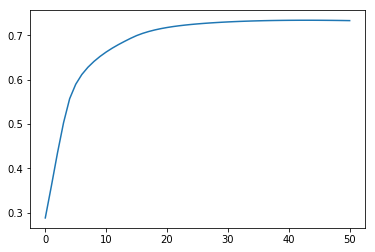

In [449]:
plt.plot(np.array(decoded_list)[:,0,0])

In [450]:
latent.shape

(501, 3)

In [460]:
steps = 50
series_length = 51
Trange = [400/5200, 1]
CO2range = [0, 1]

testT, testCO2 = np.meshgrid(np.linspace(*Trange, num=steps), np.linspace(*CO2range, num=steps))

in_test = np.vstack([np.ravel(testT), np.ravel(testCO2)]).T
in_zero = np.zeros([np.size(testT), (2 * series_length - 2)]) # padding to get right shape of input

net_prod = np.hstack([in_test, in_zero])

In [462]:
latent = net.run(net_prod, net.state_means)

Text(0.5,0,'$CO_2$')

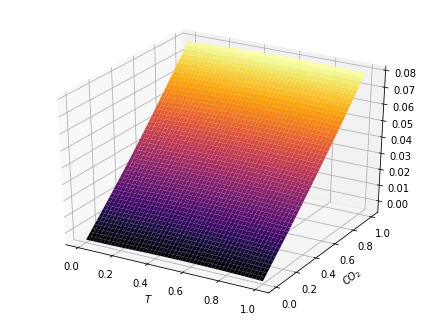

In [474]:
fig = plt.figure(figsize=(16.4, 12.2))
ax = fig.add_subplot('22{}'.format(2 * 0 + 1), projection='3d')
ax.plot_surface(testT, testCO2, latent[:, 0].reshape(testCO2.shape), cmap=cm.inferno)
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$CO_2$')

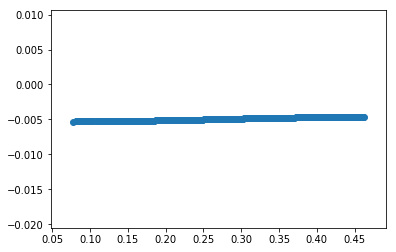

In [456]:
plt.scatter(net_test.index/5183,latent[:,0])
plt.y

In [357]:
net_test.index

Float64Index([1794.0,  753.0, 1734.0, 1306.0, 1690.0, 1674.0, 1339.0, 2132.0,
               465.0, 1447.0,
              ...
               825.0, 2275.0,  932.0, 1152.0, 1165.0, 1757.0,  808.0, 2015.0,
              1094.0, 2049.0],
             dtype='float64', name=u'initT', length=501)

In [327]:
np.array(decoded_list)[:,500,:]

array([[ 5.7210755e-01, -1.8054551e-01, -1.6403043e+00,  2.7291214e-01],
       [ 7.2390628e-01, -2.1528614e-01, -1.5633224e+00,  1.7440796e-01],
       [ 8.6904335e-01, -2.7078795e-01, -1.4873624e+00,  4.0543087e-02],
       [ 9.9230880e-01, -3.3670911e-01, -1.4095123e+00, -1.1335706e-01],
       [ 1.1056759e+00, -3.8459417e-01, -1.3198694e+00, -2.6512587e-01],
       [ 1.2119440e+00, -4.1598478e-01, -1.2129929e+00, -4.0877527e-01],
       [ 1.3107754e+00, -4.3858713e-01, -1.1147397e+00, -5.3642017e-01],
       [ 1.4007596e+00, -4.5698130e-01, -1.0326126e+00, -6.5069878e-01],
       [ 1.4851179e+00, -4.7240275e-01, -9.6848023e-01, -7.5532120e-01],
       [ 1.5704478e+00, -4.7994006e-01, -9.1764784e-01, -8.4611785e-01],
       [ 1.6553020e+00, -4.7916692e-01, -8.7702310e-01, -9.2313129e-01],
       [ 1.7431474e+00, -4.7238398e-01, -8.4634125e-01, -9.9544585e-01],
       [ 1.8352410e+00, -4.6019810e-01, -8.2443118e-01, -1.0654372e+00],
       [ 1.9319667e+00, -4.4586009e-01, -8.0666721e

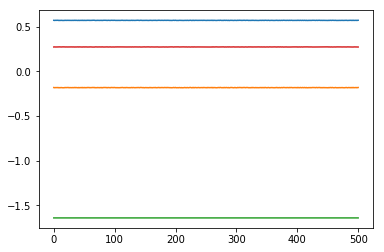

In [306]:
plt.plot(np.array(decoded_list)[0,:,:])

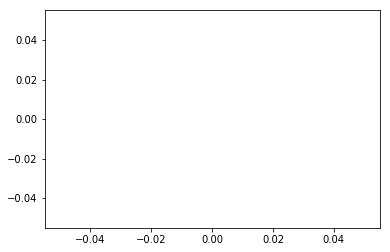

In [252]:
plt.plot(latent[:,0])

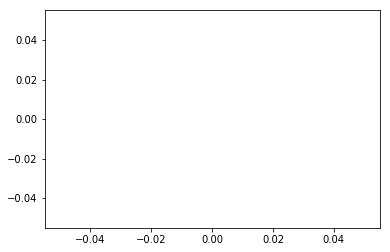

In [253]:
plt.plot(latent[:,1])

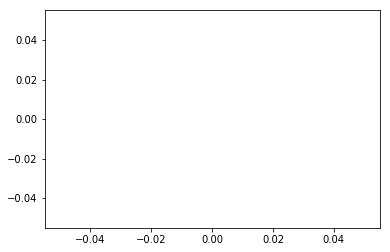

In [254]:
plt.plot(latent[:,2])

In [147]:
np.hstack([my_load_initial(df),my_load_co2(df)])

array([[ 1.00000000e+03,  1.00000000e+03,  3.33333333e-01, ...,
         3.23966353e-01,  2.56962592e-02,  6.29300014e-01],
       [ 1.00100000e+03,  1.00100000e+03,  3.33333333e-01, ...,
         3.23878998e-01,  2.59358981e-02,  6.28951539e-01],
       [ 1.00200000e+03,  1.00200000e+03,  3.33333333e-01, ...,
         3.23791035e-01,  2.61772072e-02,  6.28600635e-01],
       ...,
       [ 2.99800000e+03,  2.99800000e+03,  3.33333333e-01, ...,
         1.66214983e-01,  4.58452609e-01, -5.24714029e-14],
       [ 2.99900000e+03,  2.99900000e+03,  3.33333333e-01, ...,
         1.66214983e-01,  4.58452609e-01, -2.32192407e-14],
       [ 3.00000000e+03,  3.00000000e+03,  3.33333333e-01, ...,
         1.66214983e-01,  4.58452609e-01, -1.63118607e-14]])

### Plotting

In [3]:
def fix_jumps(theta_M):
    """
    Fixes jumps that arise because theta_M is always between -pi and pi
    """
    while True:
        diff = np.abs(theta_M[:, 1:] - theta_M[:, :-1])
        jumps = np.array(np.where(diff > 1.)).T
        if len(jumps) == 0:
            break
        fixed_lines = []
        for x, y in jumps:
            if x in fixed_lines:
                continue
            else:
                fixed_lines.append(x)
            theta_M[x, y + 1:] = theta_M[x, y + 1:] - np.sign(theta_M[x, y + 1] - theta_M[x, y]) * 2 * np.pi
    return theta_M

In [4]:
def copernicus_phi(net, series_length=20, delta_t=7, steps=50):
    layer = net.state_means
    ss = np.linspace(0, 2 * np.pi, num=steps)
    mm = np.linspace(0, 2 * np.pi, num=steps)
    S, M = np.meshgrid(ss, mm)
    data = edc.copernicus_data(series_length, delta_t=delta_t, phi_S_target=np.ravel(S), phi_M_target=np.ravel(M))[0]
    fig = plt.figure(figsize=(6.0, 2.8))
    fig.tight_layout()
    out = np.array(net.run(data, layer))
    for i in range(len(out[0])):
        zs = out[:, i]
        ax = fig.add_subplot('12{}'.format(i+1), projection='3d')
        ax.view_init(20, 60)
        Z = np.reshape(zs, S.shape)
        surf = ax.plot_surface(S, M, Z, rstride=1, cstride=1, cmap=cm.inferno, linewidth=0)
        ax.set_xlabel(r'$\phi_S$')
        ax.set_ylabel(r'$\phi_M$')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        ax.set_xticks([0, np.pi, 2*np.pi])
        ax.set_yticks([0, np.pi, 2*np.pi])
        ax.set_xticklabels(['0', r'$\pi$', r'$2 \pi$'])
        ax.set_yticklabels(['0', r'$\pi$', r'$2 \pi$'])
    return fig


In [200]:
theta_S_range = [0, 2 * np.pi]
theta_M_range = [-np.pi, np.pi]

theta_S, theta_M = np.meshgrid(np.linspace(*theta_S_range, num=100), np.linspace(*theta_M_range, num=100))

In [201]:
in_theta = np.vstack([np.ravel(theta_S), np.ravel(theta_M)]).T

In [205]:
in_theta.shape

(10000, 2)

In [202]:
in_zero = np.zeros([np.size(theta_S), (2 * 50 - 2)])

In [206]:
in_zero.shape

(10000, 98)

In [203]:
net_in = np.hstack([in_theta, in_zero])

In [204]:
net_in.shape

(10000, 100)

In [5]:
def theta_fit(net, series_length, steps=100):
    R_E = 1.
    R_M = 1.524

    dist = lambda theta_S, theta_M: R_E * np.cos(theta_S - theta_M) + np.sqrt(R_M**2 - R_E**2 * np.sin(theta_S - theta_M)**2)
    phi_E = lambda theta_S, theta_M: theta_S
    phi_M = lambda theta_S, theta_M: np.angle(R_E / R_M * np.cos(theta_S) - dist(theta_S, theta_M) / R_M * np.cos(theta_M) +
                                              1.j * (R_E / R_M * np.sin(theta_S) - dist(theta_S, theta_M) / R_M * np.sin(theta_M)))
    theta_S_range = [0, 2 * np.pi]
    theta_M_range = [-np.pi, np.pi]

    theta_S, theta_M = np.meshgrid(np.linspace(*theta_S_range, num=steps), np.linspace(*theta_M_range, num=steps))

    in_theta = np.vstack([np.ravel(theta_S), np.ravel(theta_M)]).T
    in_zero = np.zeros([np.size(theta_S), (2 * series_length - 2)]) # padding to get right shape of input

    net_in = np.hstack([in_theta, in_zero])
    zs = net.run(net_in, net.state_means)

    phi_E_vals = phi_E(theta_S, theta_M)
    phi_M_vals = fix_jumps(phi_M(theta_S, theta_M).T).T

    coeffs = [] # coefficients for fitting the network output to a linear combination of phi_E and phi_M
    for i in range(2):
        A = np.vstack([np.ravel(phi_E_vals), np.ravel(phi_M_vals), np.ones(np.size(theta_S))]).T
        coeffs.append(np.linalg.lstsq(A, zs[:, i], rcond=None)[0])

    fig = plt.figure(figsize=(16.4, 12.2))
    for i in range(2):
        ax = fig.add_subplot('22{}'.format(2 * i + 1), projection='3d')
        ax.plot_surface(theta_S, theta_M, zs[:, i].reshape(theta_M.shape), cmap=cm.inferno)
        ax.set_xlabel(r'$\theta_S$')
        ax.set_ylabel(r'$\theta_M$')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        ax = fig.add_subplot('22{}'.format(2 * i + 2), projection='3d')
        fit_z = coeffs[i][0] * phi_E_vals + coeffs[i][1] * phi_M_vals + coeffs[i][2]
        ax.plot_surface(theta_S, theta_M, fit_z, cmap=cm.inferno)
        ax.set_xlabel(r'$\theta_S$')
        ax.set_ylabel(r'$\theta_M$')
        ax.set_zlabel(r'Fit ${:.2} \, \phi_E + {:.2} \, \phi_M + {:.2}$'.format(*coeffs[i]))
    return fig

## Load pre-trained model

### Parameters
- `latent_size: 2`
- `input_size: 1` 
- `output_size: 2`
- other parameters: default values
### Data
- random_start: False (uses realistic data that could have been collected during Copernicus' lifetime)
- Training data: 95000 samples with `delta_t: 7`
- Validation data: 5000 samples with `delta_t: 7`

### Training
1. 1000 epochs with `batch_size: 256`, `learning_rate: 1e-4`, `beta: 0.1`, `euler_l2_coeff: 1`, `time_series_length: 20`
2. 1000 epochs with `batch_size: 1024`, `learning_rate: 1e-4`, `beta: 0.1`, `euler_l2_coeff: 1`, `time_series_length: 20`
3. 1000 epochs with `batch_size: 1024`, `learning_rate: 1e-4`, `beta: 0.1`, `euler_l2_coeff: 1`, `time_series_length: 50`
4. 1000 epochs with `batch_size: 2048`, `learning_rate: 1e-5`, `beta: 0.01`, `euler_l2_coeff: 1`, `time_series_length: 50`
5. 11000 epochs with `batch_size: 2048`, `learning_rate: 1e-5`, `beta: 0.001`, `euler_l2_coeff: 1`, `time_series_length: 50`

In [67]:
print(net.history['cost'])

AttributeError: 'Network' object has no attribute 'history'

  0%|          | 0/1000 [00:00<?, ?it/s]

InvalidArgumentError: Nan in summary histogram for: euler_bias_0
	 [[node euler_bias_0 (defined at /Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for u'euler_bias_0':
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/Users/wtchung/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 1017, in start
    self._run_callback(self._callbacks.popleft())
  File "/Users/wtchung/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Users/wtchung/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 263, in enter_eventloop
    self.eventloop(self)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/eventloops.py", line 239, in loop_tk
    kernel.timer.start()
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/eventloops.py", line 236, in start
    self.app.mainloop()
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/lib-tk/Tkinter.py", line 1135, in mainloop
    self.tk.mainloop(n)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/lib-tk/Tkinter.py", line 1547, in __call__
    return self.func(*args)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/lib-tk/Tkinter.py", line 596, in callit
    func(*args)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/eventloops.py", line 231, in on_timer
    self.func()
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 298, in do_one_iteration
    stream.flush(zmq.POLLIN, 1)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 364, in flush
    self._handle_recv()
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 492, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 444, in _run_callback
    callback(*args, **kwargs)
  File "/Users/wtchung/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-72-8fef239e33e7>", line 1, in <module>
    net = nn.Network(latent_size = 3,input_size =  1,output_size = 1,time_series_length = my_load_co2(df).shape[1]+1)
  File "../../nn_physical_concepts/scinet/model.py", line 52, in __init__
    self.graph_setup()
  File "../../nn_physical_concepts/scinet/model.py", line 309, in graph_setup
    tf.summary.histogram('euler_bias_{}'.format(i), b)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow_core/python/summary/summary.py", line 179, in histogram
    tag=tag, values=values, name=scope)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow_core/python/ops/gen_logging_ops.py", line 329, in histogram_summary
    "HistogramSummary", tag=tag, values=values, name=name)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/Users/wtchung/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [62]:

%tensorboard --inspect --logdir '../tf_log/Unnamed'

ERROR: Failed to launch TensorBoard (exited with 0).
Contents of stdout:
Processing event files... (this can take a few minutes)

Found event files in:
../tf_log/Unnamed

These tags are in ../tf_log/Unnamed:
audio -
histograms -
images -
scalars -
tensor -

Event statistics for ../tf_log/Unnamed:
audio -
graph
   first_step           0
   last_step            0
   max_step             0
   min_step             0
   num_steps            1
   outoforder_steps     []
histograms -
images -
scalars -
sessionlog:checkpoint -
sessionlog:start -
sessionlog:stop -
tensor -

In [6]:
net = nn.Network.from_saved('copernicus', change_params={'name': 'copernicus'})

{'decoder_num_units': [100, 100], 'tot_epochs': 15000, 'latent_size': 2, 'output_size': 2, 'time_series_length': 50, 'encoder_num_units': [100, 100], 'euler_num_units': [], 'input_size': 1, 'load_file': 'copernicus', 'name': 'copernicus'}







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








INFO:tensorflow:Restoring parameters from /Users/wtchung/Documents/CS230/final_proj/nn_physical_concepts/tf_save/copernicus.ckpt
Loaded network from file copernicus


## Plot of latent activation as a function of observed angles

Each row of the following plots corresponds to one latent neuron. Within each row, the plot on the left shows the activation of this latent neuron as a function of the observed angled $\theta_S$ and $\theta_M$. The right plot shows a fit of the latent activation to a linear combination $\phi_S(\theta_S, \theta_M)$, $\phi_M(\theta_S, \theta_M)$ (see Fig. 6a in paper for the definition of $\theta$ and $\phi$). The fact that the plots within every row look similar confirms again that SciNet has learnt a linear combination of the heliocentric angles $\phi$.

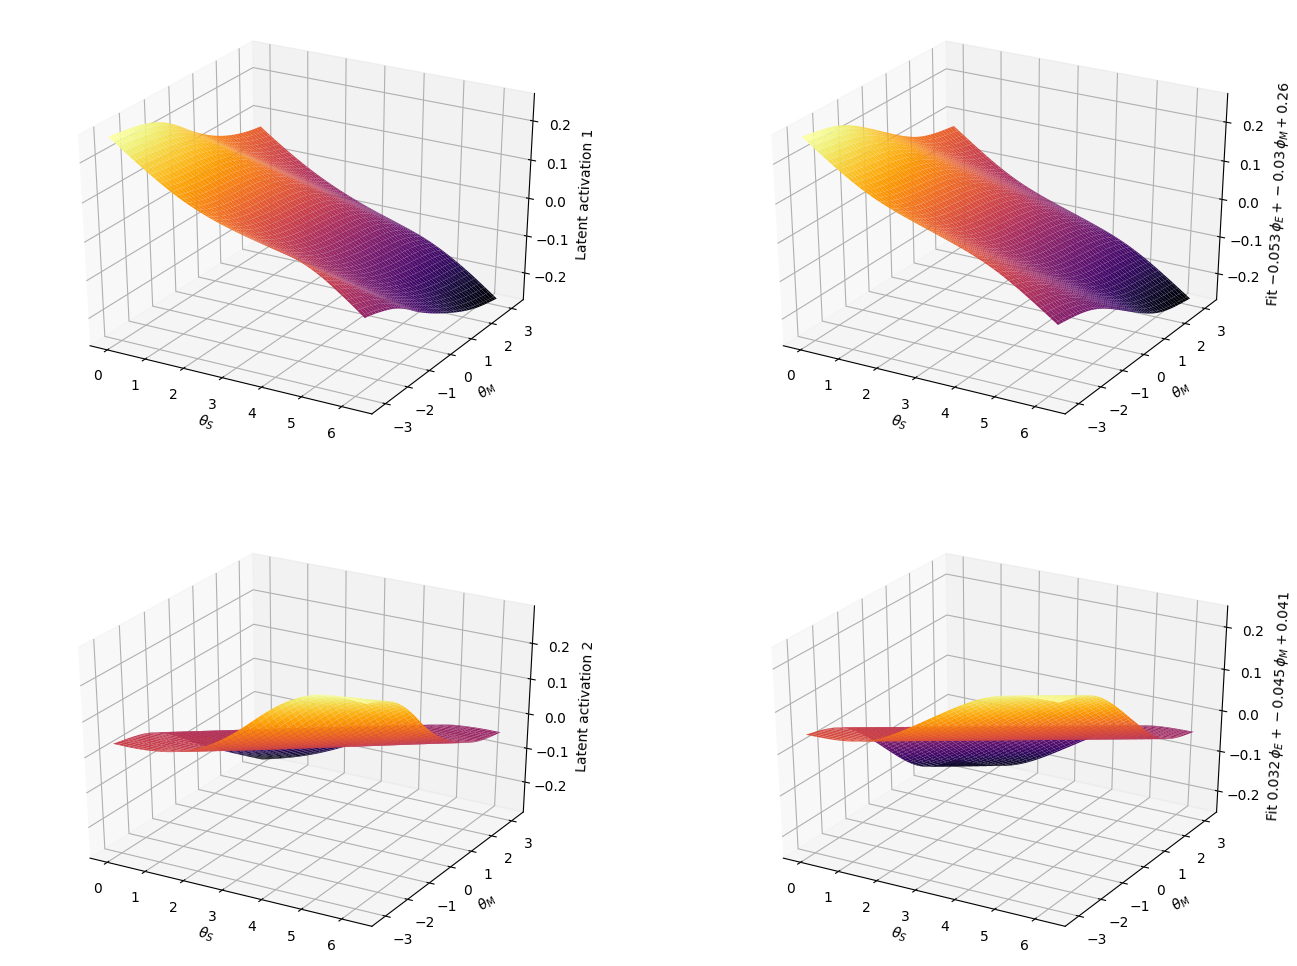

In [8]:
theta_fit(net, 50)

## Plot of latent activation as a function of heliocentric angles

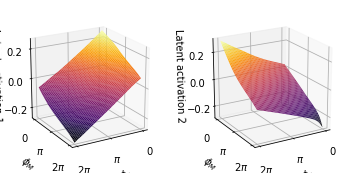

In [10]:
%matplotlib inline
fig = copernicus_phi(net, series_length=50)

### Calculate L2-norm of error

In [210]:
data, states = edc.copernicus_data(50, 2000)

In [211]:
data.shape

(2000, 100)

In [219]:
data

array([[ 3.30755445, -2.46148242,  3.42805389, ...,  1.6007465 ,
         9.21202721,  1.67710165],
       [ 4.96321367,  0.55600269,  5.08371312, ...,  4.36826718,
        10.86768644,  4.45461923],
       [ 0.64867636,  2.13447388,  0.76917581, ...,  6.12220811,
         6.55314913,  6.20818025],
       ...,
       [ 1.83486117,  2.96866878,  1.95536061, ...,  7.04365655,
         7.73933394,  7.12852408],
       [ 5.81422355, -0.88350028,  5.93472299, ...,  1.50082803,
        11.71869632,  1.49800188],
       [ 1.02263696,  1.69598722,  1.1431364 , ...,  5.78492382,
         6.92710973,  5.86513738]])

In [212]:
net_cop = nn.Network(latent_size = 3,input_size =  1,output_size = 2,time_series_length = data.shape[1]/2)

In [213]:
net_cop.train(1000, 32, 1e-4, data, data,beta_fun=lambda x: 0.1, euler_l2_coeff=0, test_step=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [215]:
latent = net_cop.run(data, net_cop.state_means)

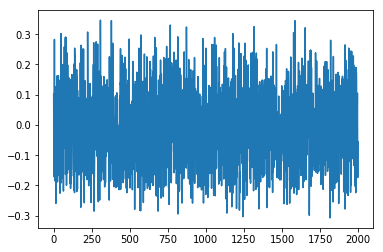

In [216]:
plt.plot(latent[:,1])

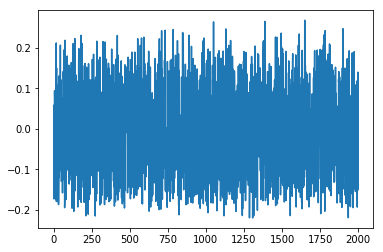

In [217]:
plt.plot(latent[:,2])

In [218]:
plt.plot(latent[:,3])

IndexError: index 3 is out of bounds for axis 1 with size 3

In [270]:
data

array([[ 3.30755445, -2.46148242,  3.42805389, ...,  1.6007465 ,
         9.21202721,  1.67710165],
       [ 4.96321367,  0.55600269,  5.08371312, ...,  4.36826718,
        10.86768644,  4.45461923],
       [ 0.64867636,  2.13447388,  0.76917581, ...,  6.12220811,
         6.55314913,  6.20818025],
       ...,
       [ 1.83486117,  2.96866878,  1.95536061, ...,  7.04365655,
         7.73933394,  7.12852408],
       [ 5.81422355, -0.88350028,  5.93472299, ...,  1.50082803,
        11.71869632,  1.49800188],
       [ 1.02263696,  1.69598722,  1.1431364 , ...,  5.78492382,
         6.92710973,  5.86513738]])

In [329]:
cop_decoded_list = net_cop.run(data, net_cop.decoded_list)

In [332]:
np.array(cop_decoded_list).shape

(50, 2000, 2)

In [333]:
np.array(cop_decoded_list)[:,:]

array([[[ 3.3098717 , -1.5237451 ],
        [ 4.9645343 ,  0.8339797 ],
        [ 0.87909836,  2.359377  ],
        ...,
        [ 1.945573  ,  3.1207232 ],
        [ 5.7842226 , -0.60871553],
        [ 1.1976362 ,  2.1025486 ]],

       [[ 3.4351518 , -1.489342  ],
        [ 5.106488  ,  0.919365  ],
        [ 0.9921805 ,  2.451548  ],
        ...,
        [ 2.0709052 ,  3.2376225 ],
        [ 5.9295473 , -0.5418497 ],
        [ 1.3127518 ,  2.1911385 ]],

       [[ 3.564043  , -1.4555569 ],
        [ 5.2327642 ,  0.9832346 ],
        [ 1.1250958 ,  2.5261905 ],
        ...,
        [ 2.2013798 ,  3.3262587 ],
        [ 6.059123  , -0.49604887],
        [ 1.4445349 ,  2.263527  ]],

       ...,

       [[ 9.164393  ,  1.103797  ],
        [10.810551  ,  3.9633837 ],
        [ 6.7436514 ,  5.811634  ],
        ...,
        [ 7.7970676 ,  6.741388  ],
        [11.629836  ,  2.2258892 ],
        [ 7.0586843 ,  5.4962525 ]],

       [[ 9.285564  ,  1.1663179 ],
        [10.926902  ,  4.02

In [336]:
cop_recon = net_cop.run(data,net_cop.recon_loss)

In [337]:
cop_recon

0.100841194